# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [98]:
!pip install pycrf
!pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


model = spacy.load("en_core_web_sm")

##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line.
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

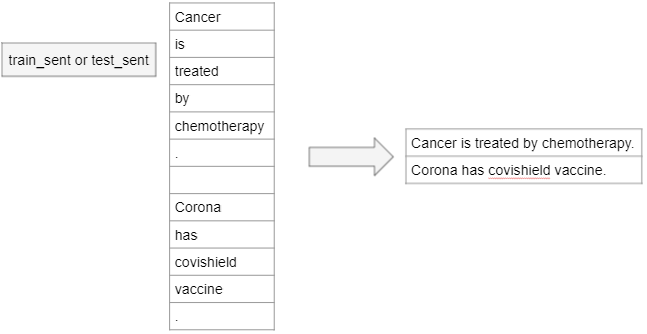

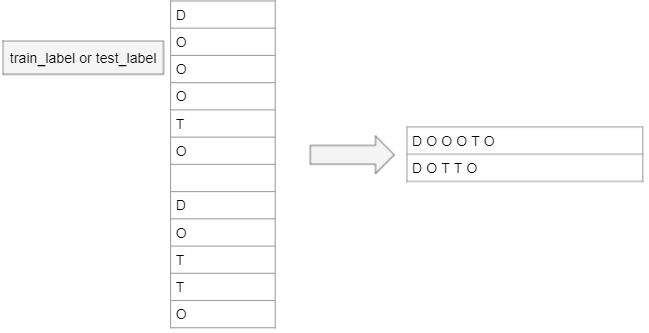

In [99]:
def sentence_formation(input_file):
    with open(input_file) as fp:
      data = fp.readlines()
    sentences = []
    temp = []
    for w in data:
      w = w.strip()
      if not w:
        sentences.append(" ".join(temp))
        temp = []
      else:
        temp.append(w)
    print(sentences)
    return sentences

In [100]:
train_sentences = sentence_formation('/content/drive/MyDrive/ML-C57/NLP/case-study/train_sent')
train_labels = sentence_formation('/content/drive/MyDrive/ML-C57/NLP/case-study/train_label')
test_sentences = sentence_formation('/content/drive/MyDrive/ML-C57/NLP/case-study/test_sent')
test_labels = sentence_formation('/content/drive/MyDrive/ML-C57/NLP/case-study/test_label')

['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )', 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )', 'Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )', "The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )", "Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )", 'Cesarean rates at tertiary care hospitals should be compared with rates at community hospitals only after correcting for dissimilar patient groups or gestational age', 'In the third trimester , the amniotic fluid index ( AFI ) may be affected by maternal fluid status

In [101]:
def plot_words_distribution(data, label):
  plt.figure(figsize=(7, 5))
  sns.countplot(data=pd.DataFrame(data, columns=["DTO"]), x="DTO")
  plt.title(label)
  plt.show()

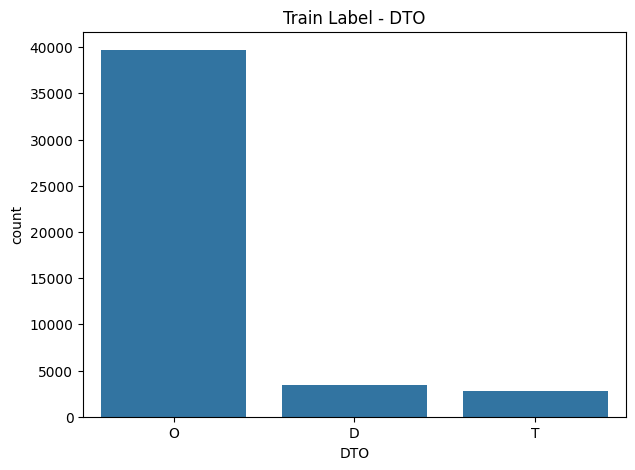

In [102]:
plot_words_distribution([x for xs in [d.split() for d in train_labels] for x in xs], 'Train Label - DTO')

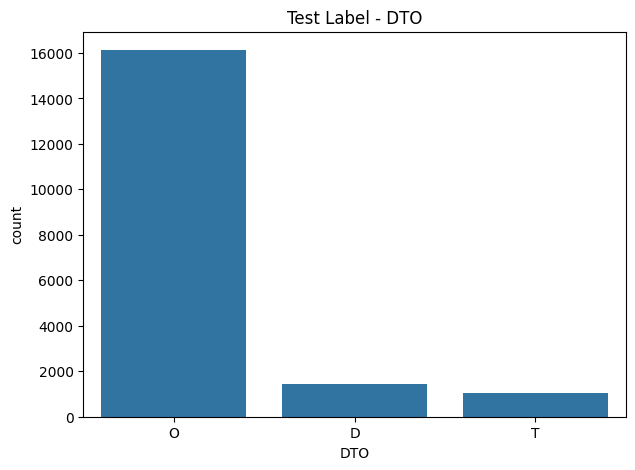

In [103]:
plot_words_distribution([x for xs in [d.split() for d in test_labels] for x in xs], 'Test Label - DTO')

In [104]:
for item in range(1):
    print(f"Sentence {item+1} is: {train_sentences[item]}")
    print(f"Label {item+1} is: {train_labels[item]}")

Sentence 1 is: All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
Label 1 is: O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O


### Count the number of sentences in the processed train and test dataset

In [105]:
print(f"Number of sentences in processed train dataset is: {len(train_sentences)}")
print(f"Number of sentences in processed test dataset is: {len(test_sentences)}")

Number of sentences in processed train dataset is: 2599
Number of sentences in processed test dataset is: 1056


### Count the number of lines of labels in the processed train and test dataset.

In [106]:
print(f"Number of lines of labels in processed train dataset is: {len(train_labels)}")
print(f"Number of lines of labels in processed test dataset is: {len(test_labels)}")

Number of lines of labels in processed train dataset is: 2599
Number of lines of labels in processed test dataset is: 1056


##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging.



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [107]:
noun_propn = []
for sentences in train_sentences + test_sentences:
    m = model(sentences)
    for t in m:
        if t.pos_ in ("NOUN", "PROPN"):
            noun_propn.append(t.text)

In [108]:
df_noun_propn = pd.Series(noun_propn)

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [109]:
df_noun_propn.value_counts().sort_values(ascending=False).head(25)

patients        492
treatment       281
%               247
cancer          200
therapy         175
study           154
disease         142
cell            140
lung            116
group            94
chemotherapy     88
gene             87
effects          85
results          79
women            77
use              74
TO_SEE           74
cases            71
surgery          71
risk             71
analysis         70
rate             67
response         66
survival         65
children         64
Name: count, dtype: int64

## Defining features for CRF





In [110]:
def get_features(sentence, pos, pos_tags):
  word = sentence[pos]

  features = [
    'word.lower=' + word.lower(),
    'word[-3:]=' + word[-3:],
    'word[-2:]=' + word[-2:],
    'word.isupper=%s' % word.isupper(),
    'word.isdigit=%s' % word.isdigit(),
    'word.startsWithCapital=%s' % word[0].isupper(),
    'word.pos=' + pos_tags[pos]
  ]

  if(pos > 0):
    prev_word = sentence[pos-1]
    features.extend([
    'prev_word.lower=' + prev_word.lower(),
    'prev_word.isupper=%s' % prev_word.isupper(),
    'prev_word.isdigit=%s' % prev_word.isdigit(),
    'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
    'prev_word.pos=' + pos_tags[pos-1]
  ])
  else:
    features.append('BEG')
  if(pos == len(sentence)-1):
    features.append('END')

  return features


## Getting the features

### Write a code/function to get the features for a sentence

In [111]:
def get_sentence_feature(sentence):
  m = model(sentence)
  postags = []
  for t in m:
      postags.append(t.pos_)
  sentences = sentence.split()
  return [get_features(sentences, pos, postags) for pos in range(len(sentences))]


### Write a code/function to get the labels of a sentence

In [112]:
def get_labels(labels):
  return labels.split()


## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset

In [113]:
X_train = [get_sentence_feature(sentence) for sentence in train_sentences]
X_test = [get_sentence_feature(sentence) for sentence in test_sentences]

### Define the labels as the target variable for test and the train dataset

In [114]:
Y_train = [get_labels(labels) for labels in train_labels]
Y_test = [get_labels(labels) for labels in test_labels]

## Build the CRF Model

In [115]:
crf = sklearn_crfsuite.CRF(max_iterations=300)
# This is to avoid an exception 'AttributeError: 'CRF' object has no attribute 'keep_tempfiles'
# The bug is reported https://github.com/TeamHG-Memex/sklearn-crfsuite/issues/60
try:
    crf.fit(X_train, Y_train)
except AttributeError:
    pass

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [116]:
Y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [117]:
f1_score = metrics.flat_f1_score(Y_test, Y_pred, average='weighted')
print(f"F1 score is: {round(f1_score,4)}")

F1 score is: 0.9103


In [118]:
len(Y_pred)

1056

##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

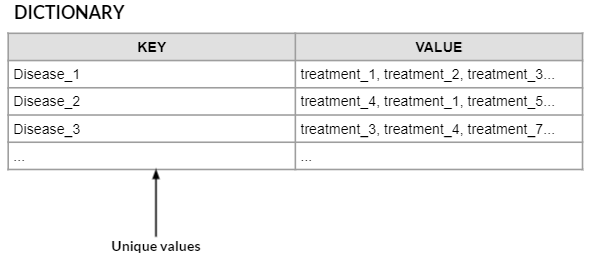

In [119]:
diseases = {}
for i, v in enumerate(Y_pred):
  d = ""
  t = ""
  s = test_sentences[i]
  for j, e in enumerate(v):
    if e == 'D':
      d = d + s.split()[j] + " "
    elif e == 'T':
      t = t + s.split()[j] + " "
  d = d.strip()
  t = t.strip()

  if d and t:
    c = diseases.get(d)
    if c:
      diseases[d] = diseases[d] + ", " +t
    else:
      diseases[d] = t

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [120]:
diseases['hereditary retinoblastoma']

'radiotherapy'